**Импорты, настройки окружения**

In [1]:
import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
import catboost as catb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

**Функция для построения красивого распределения**

In [2]:
def destrib_fig(data, trait, n_bins=25, l_space_start=0, l_space_stop=0.5, l_space_count=10, dens=True):

    target_mean = round(data[trait].mean(), 2)
    target_median = data[trait].median()
    target_mode = data[trait].mode()[0]
    target_quant005 = data[trait].quantile(0.05)
    target_quant995 = data[trait].quantile(0.995)

    plt.figure(figsize = (10, 4))
    plt.hist(data[trait], density=dens, bins=n_bins, alpha=0.5, ec='Black')

    y = np.linspace(l_space_start, l_space_stop, l_space_count)
    plt.plot([target_mean] * l_space_count, y, label='mean',  linewidth=4)
    plt.plot([target_median] * l_space_count, y, label='median',  linewidth=4)
    plt.plot([target_mode] * l_space_count, y, label='mode', linewidth=4)
    plt.plot([target_quant005] * l_space_count, y, label='Quantile 0.05', linewidth=4)
    plt.plot([target_quant995] * l_space_count, y, label='Quantile 0.995', linewidth=4)
                                 
    plt.title(f'Distribution of {trait}')
    plt.legend()
    plt.show()

**Вспомогательные функции для оценки модели**

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

**Функция для балансировки классов разными методами**

In [5]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './course_project2/course_project_train.csv'
TEST_DATASET_PATH = './course_project2/course_project_test.csv'

**Загрузка данных**

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


## 1. Обзор данных

In [9]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### 1.1 Описание датасета

* <b>Home Ownership</b> - домовладение
* <b>Annual Income</b> - годовой доход
* <b>Years in current job</b> - количество лет на текущем месте работы
* <b>Tax Liens</b> - налоговые обременения
* <b>Number of Open Accounts</b> - количество открытых счетов
* <b>Years of Credit History</b> - количество лет кредитной истории
* <b>Maximum Open Credit</b> - наибольший открытый кредит
* <b>Number of Credit Problems</b> - количество проблем с кредитом
* <b>Months since last delinquent</b> - количество месяцев с последней просрочки платежа
* <b>Bankruptcies</b> - банкротства
* <b>Purpose</b> - цель кредита
* <b>Term</b> - срок кредита
* <b>Current Loan Amount</b> - текущая сумма кредита
* <b>Current Credit Balance</b> - текущий кредитный баланс
* <b>Monthly Debt</b> - ежемесячный долг
* <b>Credit Default</b> - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### 1.3 Размер датасета

In [10]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

### 1.4 Обзор целевой переменной

In [11]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### 1.5 Обзор количественных признаков

In [12]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### 1.6 Обзор номинативных переменных

In [13]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### 1.7 Количество пропусков

In [14]:
len(train_df) - train_df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [15]:
NUM_FEATURE_NAME = train_df.select_dtypes(exclude='object').columns.drop('Credit Default')
CAT_FEATURE_NAME = train_df.select_dtypes(include='object').columns
TARGET_NAME = 'Credit Default'

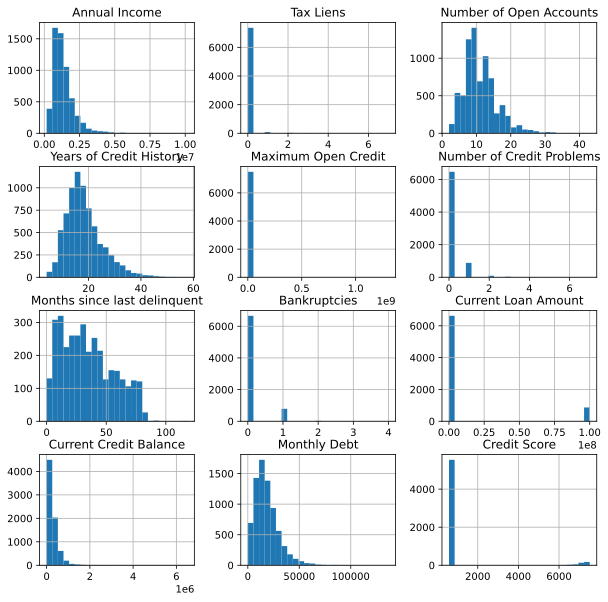

In [16]:
train_df[NUM_FEATURE_NAME].hist(figsize=(10,10), bins=25)
plt.show()

### 2.1 Months since last delinquent

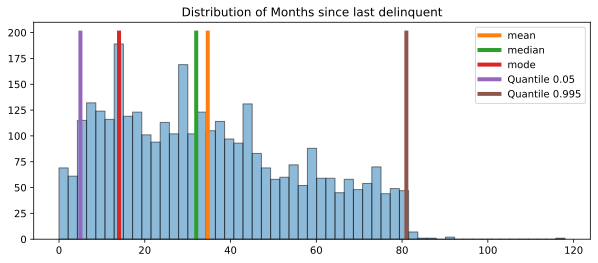

In [17]:
destrib_fig(train_df, 'Months since last delinquent', dens=False, n_bins=55, l_space_stop=200)

In [18]:
condition = (train_df['Months since last delinquent'] > 80)
train_df.loc[condition, 'Months since last delinquent'] = train_df['Months since last delinquent'].mode()[0]

### 2.2 Bankruptcies

In [19]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [20]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = 0

### 2.3 Credit Score

In [21]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [22]:
mask = train_df['Credit Score'] > 1000
train_df.loc[mask, 'Credit Score'] = train_df.loc[mask, 'Credit Score'] / 10

### 2.4 Current Loan Amount

In [23]:
cur_loan_am_max = train_df['Current Loan Amount'].max()
train_df.loc[train_df['Current Loan Amount'] == cur_loan_am_max, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

## 3.0 Обработка пропусков

In [24]:
len(train_df) - train_df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### 3.1 Years in current job

In [25]:
mask = train_df['Years in current job'].isna()
train_df.loc[mask, 'Years in current job'] = '10+ years'

### 3.2 Annual Income

In [26]:
mask = train_df['Annual Income'].isna()
train_df.loc[mask]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,NaN,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,NaN,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,NaN,10+ years,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [27]:
yea_job = train_df['Years in current job'].unique()

for elem in yea_job:
    an_inc_year = train_df.loc[train_df['Years in current job'] == elem, 'Annual Income'].median()
    train_df.loc[mask & (train_df['Years in current job']== elem), 'Annual Income'] = an_inc_year

### 3.3 Credit Score

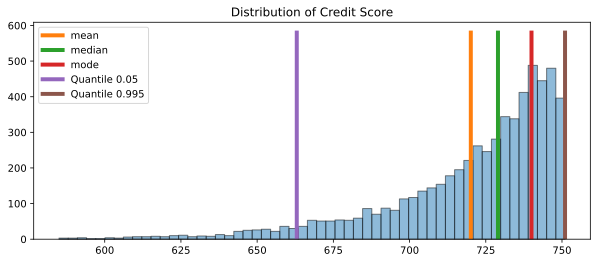

In [28]:
destrib_fig(train_df, 'Credit Score', n_bins=55, dens=False, l_space_stop=580)

In [29]:
credit_score_mode = train_df['Credit Score'].mode().tolist()
train_df['Credit Score'].fillna(credit_score_mode[0], inplace=True)

### 3.4 Months since last delinquent

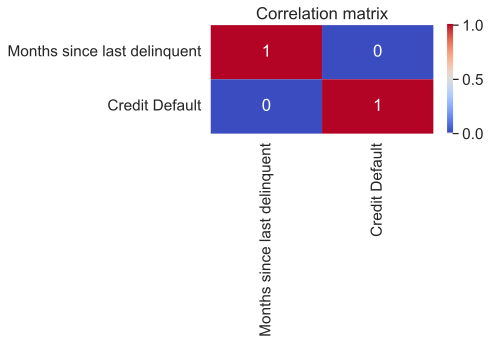

In [30]:
column = ['Months since last delinquent', 'Credit Default']

plt.figure(figsize = (5,2))

sns.set(font_scale=1.4)

corr_matrix = train_df[column].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.05, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [31]:
train_df = train_df.drop('Months since last delinquent', axis=1)

## 4. Обработка категориальных признаков

In [32]:
CAT_FEATURE_NAME

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [33]:
term_dict = {'Short Term': 0, 'Long Term': 1}
home_owner_dict = {'Home Mortgage': 1, 
                  'Rent': 0, 'Own Home': 2,
                  'Have Mortgage': 1}
year_cur_job_dict = {'10+ years': 10, '9 years': 9,
                     '8 years': 8, '7 years': 7,
                     '6 years': 6, '5 years': 5,
                     '4 years': 4, '3 years': 3,
                     '2 years': 2, '1 year': 1,
                     '< 1 year': 0,}
purpose_dict = {'debt consolidation': 0,
                'other': 1,
                'home improvements': 1,
                'take a trip': 1,
                'buy a car': 1,
                'small business': 2,
                'business loan': 2,
                'wedding': 1,
                'educational expenses': 1,
                'buy house': 1,
                'medical bills': 1,
                'moving': 1,
                'major purchase': 1,
                'vacation':1,
                'renewable energy':1, }

In [34]:
train_df['Ownership'] = train_df['Home Ownership'].copy().replace(home_owner_dict)
train_df['Term type'] = train_df['Term'].copy().replace(term_dict)
train_df['Years in current job new'] = train_df['Years in current job'].copy().replace(year_cur_job_dict)
train_df['Purpose_r'] = train_df['Purpose'].copy().replace(purpose_dict)

## 5. Подготовка тестового датасета.

In [35]:
def prediction(df):
    
    term_dict = {'Short Term': 0, 'Long Term': 1}
    home_owner_dict = {'Home Mortgage': 1, 
                  'Rent': 0, 'Own Home': 2,
                  'Have Mortgage': 1}
    year_cur_job_dict = {'10+ years': 10, '9 years': 9,
                     '8 years': 8, '7 years': 7,
                     '6 years': 6, '5 years': 5,
                     '4 years': 4, '3 years': 3,
                     '2 years': 2, '1 year': 1,
                     '< 1 year': 0,}
    purpose_dict = {'debt consolidation': 0,
                'other': 1,
                'home improvements': 1,
                'take a trip': 1,
                'buy a car': 1,
                'small business': 2,
                'business loan': 2,
                'wedding': 1,
                'educational expenses': 1,
                'buy house': 1,
                'medical bills': 1,
                'moving': 1,
                'major purchase': 1,
                'vacation':1,
                'renewable energy':1, }
    
    # Months since last delinquent
    df.drop('Months since last delinquent', axis=1)
    
    # Bankruptcies
    df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0
    
    #Credit Score
    mask = df['Credit Score'] > 1000
    df.loc[mask, 'Credit Score'] = df.loc[mask, 'Credit Score'] / 10
    credit_score_mode = df['Credit Score'].mode().tolist()
    df['Credit Score'].fillna(credit_score_mode[0], inplace=True)
    
    # Current Loan Amount
    cur_loan_am_max = df['Current Loan Amount'].max()
    df.loc[df['Current Loan Amount'] == cur_loan_am_max, 'Current Loan Amount'] = \
                                                        df['Current Loan Amount'].median()
    # Years in current job
    mask = df['Years in current job'].isna()
    df.loc[mask, 'Years in current job'] = '10+ years'
    
    # Annual Income
    yea_job = df['Years in current job'].unique()
    for elem in yea_job:
        an_inc_year = df.loc[df['Years in current job'] == elem, 'Annual Income'].median()
        df.loc[mask & (df['Years in current job']== elem), 'Annual Income'] = an_inc_year
   
    # Home Ownership
    df['Ownership'] = df['Home Ownership'].copy().replace(home_owner_dict)
    
    # Term 
    df['Term type'] = df['Term'].copy().replace(term_dict)
    
    # Years in current job
    df['Years in current job new'] = df['Years in current job'].copy().replace(year_cur_job_dict)
    
    # Purpose
    df['Purpose_r'] = df['Purpose'].copy().replace(purpose_dict)
    
    return df

In [36]:
test_df = prediction(test_df)

## 6. Выбор признаков для обучения модели и обучение модели

In [37]:
MY_COLUMNS = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
          'Maximum Open Credit', 'Number of Credit Problems', 
           'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
          'Ownership', 'Term type', 'Years in current job new', 'Purpose_r']
TARGET_NAME = ['Credit Default']

In [38]:
X = train_df[MY_COLUMNS]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=24)

In [39]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

Credit Default
0.0               3769
1.0               1895
dtype: int64

In [40]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5449020931802835

In [41]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                    #  cat_features=CAT_FEATURE_NAMES,
                                    class_weights=[1, disbalance],
                                    allow_writing_files=False,
                                    learning_rate=0.2,
                                    max_depth=3,
                                    n_estimators=95,
                                    eval_metric='F1',
                                    reg_lambda=2.617721518987342,
                                    early_stopping_rounds=30,
                                    use_best_model=True,
                                    custom_metric=['Precision', 'Recall'],
                                    subsample=0.8,)
                                     
model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.62      0.73      3769
           1       0.45      0.77      0.57      1481

    accuracy                           0.67      5250
   macro avg       0.66      0.70      0.65      5250
weighted avg       0.75      0.67      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1618
           1       0.41      0.72      0.52       632

    accuracy                           0.63      2250
   macro avg       0.63      0.66      0.61      2250
weighted avg       0.72      0.63      0.65      2250



In [42]:
f1_score(y_test, model_catb.predict(X_test))

0.520138089758343

In [43]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
6,Current Loan Amount,49.206300
0,Annual Income,9.892083
9,Credit Score,9.804600
11,Term type,8.094936
3,Maximum Open Credit,6.244940
8,Monthly Debt,4.724959
7,Current Credit Balance,4.191248
10,Ownership,2.534186
2,Number of Open Accounts,2.505875
13,Purpose_r,1.169862


In [44]:
predictions = model_catb.predict(test_df[MY_COLUMNS])
predictions = predictions.astype('int32')
predictions

array([1, 0, 1, ..., 1, 0, 1])

In [45]:
predictions = pd.DataFrame(predictions)
predictions

,0
0,1
1,0
2,1
3,1
4,0
...,...
2495,0
2496,1
2497,1
2498,0


In [46]:
SAMPLE_SUBMISSION = "./course_project2/ADavydov_predictions.csv"
submit = pd.read_csv(SAMPLE_SUBMISSION)

In [47]:
submit['Credit Default'] = predictions

submit.head()

,0,Credit Default
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0


In [48]:
predictions.to_csv(SAMPLE_SUBMISSION, index = False)